In [19]:
import pandas as pd
import numpy as np
import re

# 读取数据
df = pd.read_excel('data.xlsx')

# 1. 末次月经：转为日期类型
df['末次月经'] = pd.to_datetime(df['末次月经'], errors='coerce')

# 2. IVF妊娠：保留原分类（自然受孕 / IUI（人工授精））
# 如果后续建模需要，可以用 pd.get_dummies(df['IVF妊娠'])

# 3. 检测孕周：12w+3 → 浮点型孕周
def parse_gestational_age(ga_str):
    if pd.isnull(ga_str):
        return np.nan
    match = re.match(r'(\d+)w\+(\d+)', str(ga_str))
    if match:
        weeks = int(match.group(1))
        days = int(match.group(2))
        return weeks + days / 7
    else:
        return np.nan

df['检测孕周_周数'] = df['检测孕周'].apply(parse_gestational_age)

# 4. 染色体的非整倍体：保留原文本（可为空）
# 无需处理，缺失值保留

# 5. 怀孕次数：>=3 → 3
def parse_pregnancy_count(val):
    if pd.isnull(val):
        return 3
    if str(val).strip() == '>=3':
        return 3
    try:
        return int(val)
    except:
        return 3

df['怀孕次数'] = df['怀孕次数'].apply(parse_pregnancy_count)

# 6. 胎儿是否健康：是/否 → 1/0
df['胎儿是否健康'] = df['胎儿是否健康'].map({'是': 1, '否': 0})


# 删除末次月经列为空的
df = df.dropna(subset=['末次月经'])


# 末次月经数据是YYYY-MM-DD,直接转为时间戳
df['末次月经'] = df['末次月经'].astype(np.int64) // 10**9


# 检测日期格式是YYYYMMDD，转为时间戳
df['检测日期'] = pd.to_datetime(df['检测日期'], format='%Y%m%d').astype(np.int64) // 10**9


# 将 染色体的非整倍体 列的空值转为0
df['染色体的非整倍体'] = df['染色体的非整倍体'].fillna(0)


# IVF妊娠列包含自然和人工，将自然受孕对应为0，人工授精对应为1
df['IVF妊娠'] = df['IVF妊娠'].map({'自然受孕': 0, 'IUI（人工授精）': 1})


# 去除列名多余的空格
df.rename(columns={c: c.strip() for c in df.columns}, inplace=True)


# 输出清洗后的数据
df.to_csv('data_cleaned.csv', index=False)

print("数据清洗完成，已保存为 data_cleaned.xlsx")


数据清洗完成，已保存为 data_cleaned.xlsx


与 Y染色体浓度 的相关性（清洗+填充后）：
Y染色体浓度          1.000000
X染色体浓度          0.456158
检测抽血次数          0.321870
末次月经           -0.272502
检测日期           -0.229831
体重             -0.180122
18号染色体的Z值      -0.160570
孕妇BMI          -0.156881
Y染色体的Z值         0.154519
X染色体的Z值        -0.115879
被过滤掉读段数的比例      0.107449
在参考基因组上比对的比例   -0.107242
身高             -0.097086
重复读段的比例         0.095982
18号染色体的GC含量    -0.079711
原始读段数          -0.076996
唯一比对的读段数       -0.074502
年龄             -0.072476
13号染色体的GC含量    -0.070625
检测孕周_周数         0.067775
13号染色体的Z值      -0.052197
21号染色体的GC含量    -0.049722
GC含量           -0.044083
21号染色体的Z值       0.025403
怀孕次数            0.005168
生产次数            0.005021
IVF妊娠                NaN
胎儿是否健康               NaN
Name: Y染色体浓度, dtype: float64


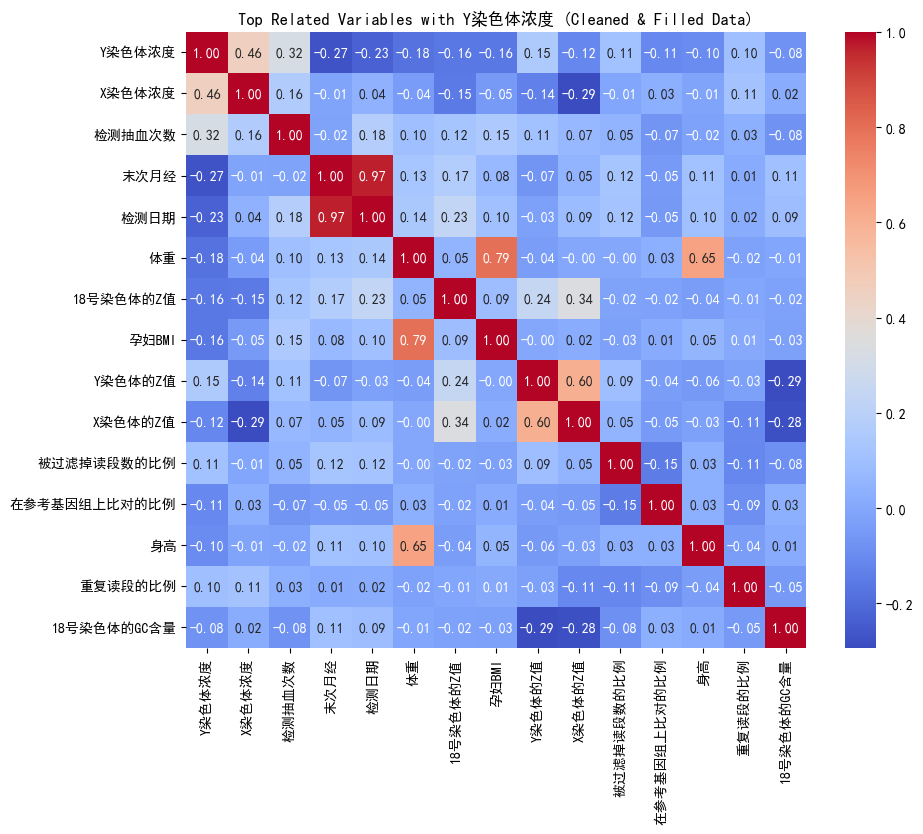

筛选出的自变量（相关性 > 0.2）：
['X染色体浓度', '检测抽血次数', '末次月经', '检测日期']


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取数据
df = pd.read_csv('data_cleaned.csv')

# 2. 只保留关键列非空（Y染色体浓度）
df_male = df[df['Y染色体浓度'].notnull()]

# 3. 只保留数值型列
numeric_df = df_male.select_dtypes(include=['float64', 'int64'])

numeric_df = numeric_df.drop(['序号'], axis=1)


# 4. 缺失值填充（这里用列的中位数填充，你也可以改成均值或0）
numeric_df_filled = numeric_df.apply(lambda col: col.fillna(col.median()))

# 5. 3σ准则剔除异常值（按列处理）
def three_sigma_filter(df):
    df_filtered = df.copy()
    for col in df_filtered.columns:
        mean = df_filtered[col].mean()
        std = df_filtered[col].std()
        mask = (df_filtered[col] >= mean - 3*std) & (df_filtered[col] <= mean + 3*std)
        df_filtered = df_filtered[mask]
    return df_filtered

numeric_df_clean = three_sigma_filter(numeric_df_filled)

# 6. 计算相关系数矩阵（pairwise 方式，自动忽略缺失值）
corr_matrix = numeric_df_clean.corr(method='pearson')

# 7. 提取与 Y染色体浓度 的相关性
target_corr = corr_matrix['Y染色体浓度'].sort_values(key=abs, ascending=False)

# 排序后输出
target_corr = target_corr.sort_values(key=abs, ascending=False)
print("与 Y染色体浓度 的相关性（清洗+填充后）：")
print(target_corr)

# 8. 可视化热力图（前15个相关性最高的变量）
top_vars = target_corr.index[:15]
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_vars, top_vars], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top Related Variables with Y染色体浓度 (Cleaned & Filled Data)')
plt.show()

# 9. 根据阈值筛选变量（绝对相关性 > 0.2）
threshold = 0.2
selected_vars = target_corr[abs(target_corr) > threshold].index.tolist()
selected_vars = [v for v in selected_vars if v != 'Y染色体浓度']

print(f"筛选出的自变量（相关性 > {threshold}）：")
print(selected_vars)
